In [1]:
import numpy as np
import pickle as pkl
import json
import torch
import librosa
import os
import sys
import cv2
import shutil
from matplotlib import pyplot as plt
import csv
import shutil
from datetime import datetime
import soundfile as sf
import whisper_timestamped
from sklearn.mixture import GaussianMixture
# import utility functions
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
import python_speech_features as psf
from transformers import BertTokenizer, BertModel

sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')
# sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Related Functions

In [3]:
def dx_dt(x: np.array, dt: float = 1, method=1):
    """
    This functio compute first derivative for the input function x using either central or forward differences

    :param x: input array to compute derivative, should be of shape [num of timestamp, num of attributes]
    :param dt: time stamp size
    :param method: method of computing derivative. 1 is forward difference, 2 is central differences
    :return: dx/dt, would be the same size as x. The first and last element are zero.
    """
    out_dx_dt = np.zeros(x.shape)
    if len(x.shape) == 2:
        for j in range(0, x.shape[1]):
            if method == 1:
                for i in range(0, x.shape[0] - 1):
                    out_dx_dt[i, j] = (x[i + 1, j] - x[i, j])/dt
                out_dx_dt[-1, j] = out_dx_dt[-2, j]
            if method == 2:
                for i in range(1, x.shape[0] - 1):
                    out_dx_dt[i, j] = (x[i + 1, j] - x[i - 1, j]) / 2 / dt
                out_dx_dt[-1, j] = out_dx_dt[-2, j]
                out_dx_dt[0, j] = out_dx_dt[1, j]
    elif len(x.shape) == 1:
        if method == 1:
            for i in range(0, x.shape[0] - 1):
                out_dx_dt[i] = (x[i + 1] - x[i]) / dt
            out_dx_dt[-1] = 0
        if method == 2:
            for i in range(1, x.shape[0] - 1):
                out_dx_dt[i] = (x[i + 1] - x[i - 1]) / 2 / dt
            out_dx_dt[-1] = 0
            out_dx_dt[0] = 0
    return out_dx_dt

def rotation_angles_frome_positions(arr):
    """
    converts an array of positions to an array of rotation angles (azimuth, elevation)
    centered at the origin, where:
        azimuth: +right,-left
        elevation: +up,-down
    here we assume that the input vectors are in world coordinates
    :param arr: array with shape (N, 3)
    :return: array with shape (N, 2)
    """
    # F: arr (N, 3) -> arr (N, 2) or arr (3, ) -> (2, )
    # in the output is in the convention of (azimuth, elevation)
    if len(arr.shape) == 2:
        mag = np.sqrt(np.sum(arr * arr, axis=1, keepdims=True))
        out = arr / mag
        out[:, 0] = np.arcsin(out[:, 0])
        out[:, 1] = np.arcsin(out[:, 1])
        return out[:, 0:2] * 180 / np.pi
    else:
        mag = np.sqrt(np.sum(arr * arr))
        out = arr / mag
        out[0] = np.arcsin(out[0])
        out[1] = np.arcsin(out[1])
        return out[0:2] * 180 / np.pi
def get_valid_shots(shots, fps, shot_length_mininmum=5):
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for shot in shots:
        start = shot[0]
        end = shot[1]
    # load the input shots range
    valid_shots_time, valid_shots_frames = [], []
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for i in range(len(shots)):
        start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        end = datetime.strptime(shots[i][1], '%H:%M:%S.%f').timestamp()
        if (end-start) >= shot_length_mininmum:
            start_t = start-t0
            end_t = end - t0
            valid_shots_time.append([start-t0, end-t0])
            valid_shots_frames.append([int(np.round(start_t*fps)), int(np.round(end_t*fps))])

    return valid_shots_time, valid_shots_frames
def load_head_and_gaze_angles(all_gaze_data, all_head_data):

    # head data
    head_angle_data = all_head_data["HEAD"]
    head_rotmat_per_frame = head_angle_data["ROTMAT"]
    head_bbox_per_frame = all_head_data["BBOX"] # we are not using but having it here is nice
    head_angle_per_frame = []
    neutral_position = np.array([0, 0, 100])
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position
        head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
    head_angle_per_frame = np.array(head_angle_per_frame)
    # getting rotation angle in z direction
    neutral_position2 = np.array([0, 100, 0])
    head_angle_z_per_frame = []
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position2
        pos = np.array([pos[1], pos[2], pos[0]])
        head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
    head_angle_xy_per_frame = np.array(head_angle_per_frame)
    head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
    head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

    # getting gaze data
    gaze_angle_data = all_gaze_data["RAW_GAZE"]
    gaze_angle_per_frame = gaze_angle_data["EULER"]
    gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
    blinks = all_head_data["BLINKS"]
    gaze_vec = np.array([0, 0, 100])
    eye_angle_per_frame = []
    for i in range(0, gaze_rotmat_per_frame.shape[0]):
        eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
        eye_line = eye_line / eye_line[2] * 100
        eye_angle_per_frame.append(eye_line)
    eye_angle_per_frame = np.array(eye_angle_per_frame)
    eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])
    return eye_angle_per_frame, head_angle_per_frame

def find_index(lst, t):
    for i in range(0, len(lst)):
        if t >= lst[i][0] and t <= lst[i][1]:
            return i, lst[i]
        elif t <= lst[i][0]:
            if i > 0:
                return -1, [lst[i-1][1], lst[i][0]]
            else:
                return -1, [-1, lst[i][0]] # assume the silence started before the current frame
        if i == len(lst) - 1:
            return -1, [lst[i][1], lst[i][1]+1]  # assume the silence ends after the current frame

def generate_sentence_structure_values_real(ts, sentence_interval):
    if len(sentence_interval) == 0:
        output_vector = np.zeros([ts.shape[0], 6])
        return output_vector
    output_vector = np.zeros([ts.shape[0], 6])
    # features
    # time since start of word (0 in silence, which means it will start at zero)
    # time till end of word (0 in silence as well,)
    # length of sentence 
    # time since start of silence (0 when speaking)
    # time till end of silence (0 when speaking)
    # length of silence
    for i in range(0, ts.shape[0]):
        t = ts[i]
        index, [start, end] = find_index(sentence_interval, t)
        if index == -1:
            output_vector[i, 3] = t - start
            output_vector[i, 4] = t - end
            output_vector[i, 5] = start - end
        else:
            output_vector[i, 0] = t - start
            output_vector[i, 1] = t - end
            output_vector[i, 2] = start - end
    return output_vector

def parse_for_sentence_intervals(transcript, threshold=0.5):
    if len(transcript) == 0:
        return [], []
    sentence_intervals = [] # this is used to only store [[start, end]]
    sentence_words = [] # this is used to store [[all words of sentence]]
    current_sentence = [transcript[0]]
    for i in range(1, len(transcript)):
        word = transcript[i]["text"]
        start = transcript[i]["start"]
        end = transcript[i]["end"]
        if start - current_sentence[-1]["end"] >= threshold:
            sentence_words.append(current_sentence)
            sentence_intervals.append([current_sentence[0]["start"], current_sentence[-1]["end"]])
            current_sentence = [transcript[i]]
        else:
            current_sentence.append(transcript[i])
    return sentence_intervals, sentence_words


# Input Block

In [2]:
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
output_folder = "/Volumes/EVAN_DISK/MASC/deep_learning_processed_dataset/"
input_folder = "/scratch/ondemand27/evanpan/data/Ribshabh_processed_dataset/"
output_folder = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/"

new_output_folder = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset_real_time_aug/"
redo = False
target_fps = 25
window_length = 10 # this is in seconds
stride_length = 5  # this is also in seconds (we get some overlapps)
output_json_path = os.path.join(output_folder, "metadata.json")

# Modified pipeline

Original Pipeline:
1. Per shot generation of gaze, head, blink, aversion
1. Per shot cutting of audio
2. Per shot transcript generation through whisper is done
3. Per shot generation aversion label
4. Window-fication + resampling of gaze, head, blink, Aversion annotation. 
4. Per-window generation + resampling of audio (MFCC) features, bert features
5. Per-window storage of interlocutor_direction 
6. Per shot generation of sentence + word structures
7. Window-ficatio + resampling of sentence + word structure data
    

Our pipeline Therefore only have to do the following

We don't have to do part 1 - 4, we simply do:
1. Per shot generation of sentence + word timing
2. Per shot generation of POS
3. Per shot generation of audio features (MFCC?)
4. Per shot generation of interlocutor direction
5. Per shot resampling of all features (to 25 fps)

We then simply need to construct a new dataloader to load all the data at once, and perform slices in real time......

## Make folder structure

In [10]:

if redo:
    try:
        os.mkdir(new_output_folder)
    except:
        shutil.rmtree(new_output_folder)
        os.mkdir(new_output_folder)
    # these are before resampling
    os.mkdir(os.path.join(new_output_folder, "taudio")) # this one will have MFCC, intensity, 
    os.mkdir(os.path.join(new_output_folder, "ttext")) # this one give the text per 
    os.mkdir(os.path.join(new_output_folder, "tgaze")) # this will store the per time-stamp.
    os.mkdir(os.path.join(new_output_folder, "thead")) # this one one is also per time-stamp
    os.mkdir(os.path.join(new_output_folder, "tfixation")) # this will have the gaze fixation. 
    os.mkdir(os.path.join(new_output_folder, "tblinks")) # this one is 
    os.mkdir(os.path.join(new_output_folder, "taversion_label")) # this one is also one per time frame
    os.mkdir(os.path.join(new_output_folder, "tsentence_timing")) # sentence timing
    os.mkdir(os.path.join(new_output_folder, "tword_POS")) # part of speech
    os.mkdir(os.path.join(new_output_folder, "tinterlocutor_direction")) # sentence timing

    # These are after resampling
    os.mkdir(os.path.join(new_output_folder, "audio")) # this one will have MFCC, intensity, 
    os.mkdir(os.path.join(new_output_folder, "text")) # this one give the text per 
    os.mkdir(os.path.join(new_output_folder, "gaze")) # this will store the per time-stamp.
    os.mkdir(os.path.join(new_output_folder, "head")) # this one one is also per time-stamp
    os.mkdir(os.path.join(new_output_folder, "fixation")) # this will have the gaze fixation. 
    os.mkdir(os.path.join(new_output_folder, "blinks")) # this one is 
    os.mkdir(os.path.join(new_output_folder, "aversion_label")) # this one is also one per time frame
    os.mkdir(os.path.join(new_output_folder, "long_aversion_label")) # this one is also one per time frame
    os.mkdir(os.path.join(new_output_folder, "sentence_timing")) # sentence timing
    os.mkdir(os.path.join(new_output_folder, "word_POS")) # part of speech
    os.mkdir(os.path.join(new_output_folder, "interlocutor_direction")) # sentence timing



## Load metadata about videos

In [12]:
# obtain all the file_paths
# video_metadata_path = os.path.join(*[input_folder, "local_metadata.json"])
# video_metadatas = json.load(open(video_metadata_path))
# video_names = list(video_metadatas.keys())

video_names_path = os.path.join(*[output_folder, "metadata.json"])
video_metadata = {}
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]


## Load Step 1 to 4 data into the new temp folders (i,e, taudio, tgaze, thead......)

In [28]:
for shot_id in range(0, len(video_metadata)):
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    # load all the files from the previous output folder, and output them into a new one
    gaze = pkl.load(open(os.path.join(*[output_folder, "tgaze", file_name+".pkl"]), "rb"))
    head = pkl.load(open(os.path.join(*[output_folder, "thead", file_name+".pkl"]), "rb"))
    blinks = pkl.load(open(os.path.join(*[output_folder, "tblinks", file_name+".pkl"]), "rb"))
    transcript_on_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(0)]), "rb"))["text"]
    transcript_off_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(1)]), "rb"))["text"]
    audio_on_screen, sr = librosa.load(os.path.join(*[output_folder, "taudio", file_name+"_{}.wav".format(0)]), sr=None)
    audio_off_screen, sr = librosa.load(os.path.join(*[output_folder, "taudio", file_name+"_{}.wav".format(1)]), sr=None)
    aversion = pkl.load(open(os.path.join(*[output_folder, "taversion_label", file_name+".pkl"]), "rb"))

    # save the files into the new location 
    pkl.dump(gaze, open(os.path.join(*[new_output_folder, "tgaze", file_name+".pkl"]), "wb"))
    pkl.dump(head, open(os.path.join(*[new_output_folder, "thead", file_name+".pkl"]), "wb"))
    pkl.dump(blinks, open(os.path.join(*[new_output_folder, "tblinks", file_name+".pkl"]), "wb"))
    pkl.dump(aversion, open(os.path.join(*[new_output_folder, "taversion_label", file_name+".pkl"]), "wb"))
    json.dump({"text": transcript_on_screen}, open(os.path.join(*[new_output_folder, "ttext", file_name+"_{}.json".format(0)]), "w"))
    json.dump({"text": transcript_off_screen}, open(os.path.join(*[new_output_folder, "ttext", file_name+"_{}.json".format(1)]), "w"))
    sf.write(os.path.join(*[new_output_folder, "taudio", file_name+"_{}.wav".format(0)]), audio_on_screen, sr)
    sf.write(os.path.join(*[new_output_folder, "taudio", file_name+"_{}.wav".format(1)]), audio_off_screen, sr)

    # additional ones
    interlocutor_direction = pkl.load(open(os.path.join(*[output_folder, "tinterlocutor_direction", file_name+".pkl"]), "rb"))
    pkl.dump(interlocutor_direction, open(os.path.join(*[new_output_folder, "tinterlocutor_direction", file_name+".pkl"]), "wb"))
    

## Part of speech tagging per shot

In [97]:
UNIVERSAL_TAGS_modification = {
    "VERB":0,
    "NOUN":1,
    "PRON":2,
    "ADJ":3,
    "ADV":4,
    "ADP":5,
    "CONJ":6,
    "DET":7,
    "NUM":8,
    "PRT":9,
    # these are not in the original set of tags
    "?":10,
    "me":11,
    "you":12,
    "UH":13
}
WORDS_FOR_I = set(["i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves", "ourself"])
WORDS_FOR_YOU = set(["you", "your", "yours", "yourself", "yourselves"])

In [115]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
def get_POS_of_sentence(transcript):
    sentence = [] # used to store each word in the sentence (in the sense of whisper)
    tokens_per_word = [] # use to store the token per word (by NLTK)
    token_map = []
    start = 0
    # first get POS and the simplified POS of all words
    for i in range(0, len(transcript)):
        per_word_token_map = []
        word = transcript[i]['text']
        tokens_per_word.append(nltk.word_tokenize(word))
        for t in tokens_per_word[-1]:
            per_word_token_map.append(start)
            start += 1
        token_map.append(per_word_token_map)
        sentence.append(word)
    sentence = " ".join(sentence)
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    simplifiedTags = [(word, nltk.tag.map_tag('en-ptb', 'universal', tag)) for word, tag in tagged]
    output_onehots = []
    # per word POS tag
    for i in range(0, len(token_map)):
        # one vector per whisper word
        vec = np.zeros([14])
        # both tags and simplified tags
        tags_per_word = tagged[token_map[i][0]:token_map[i][-1]+1]
        simplified_tags_per_word = simplifiedTags[token_map[i][0]:token_map[i][-1]+1]
        # print(tags_per_word, simplified_tags_per_word, lemmatizer.lemmatize(tags_per_word[0][0]))
        for t in range(0, len(simplified_tags_per_word)):
            # get question mark
            if simplified_tags_per_word[t][0] == "?":
                vec[10] = 1
            # get interjections:
            elif tags_per_word[t][1] == "UH":
                vec[13] = 1
            # if it is a pronoun, we will check for i or you
            elif simplified_tags_per_word[t][1] == "PRON":
                if lemmatizer.lemmatize(tags_per_word[t][0]).lower() in WORDS_FOR_I:
                    vec[11] = 1
                elif lemmatizer.lemmatize(tags_per_word[t][0]).lower() in WORDS_FOR_YOU:
                    vec[12] = 1 
                else:
                    vec[UNIVERSAL_TAGS_modification[simplified_tags_per_word[t][1]]] = 1
            else:
                if simplified_tags_per_word[t][1] != ".":
                    vec[UNIVERSAL_TAGS_modification[simplified_tags_per_word[t][1]]] = 1
        output_onehots.append(vec.tolist())
    return output_onehots
        


[nltk_data] Downloading package punkt to /u8/c/evanpan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /u8/c/evanpan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /u8/c/evanpan/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /u8/c/evanpan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /u8/c/evanpan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [120]:
# also record the distribution of all 
sum_of_dict = np.zeros([14])
for shot_id in range(0, len(video_metadata)):
    transcript_on_screen = json.load(open(os.path.join(*[new_output_folder, "ttext", video_metadata[shot_id]["name"]+"_{}.json".format(0)]), "rb"))["text"]
    transcript_off_screen = json.load(open(os.path.join(*[new_output_folder, "ttext", video_metadata[shot_id]["name"]+"_{}.json".format(1)]), "rb"))["text"]
    on_screen_text_POS_tags = get_POS_of_sentence(transcript_on_screen)
    off_screen_text_POS_tags = get_POS_of_sentence(transcript_off_screen)
    on_screen_text_POS_save_path = os.path.join(*[new_output_folder, "tword_POS", video_metadata[shot_id]["name"]+"_{}.pkl".format(0)])
    off_screen_text_POS_save_path = os.path.join(*[new_output_folder, "tword_POS", video_metadata[shot_id]["name"]+"_{}.pkl".format(1)])
    pkl.dump(on_screen_text_POS_tags, open(on_screen_text_POS_save_path, "wb"))
    pkl.dump(off_screen_text_POS_tags, open(off_screen_text_POS_save_path, "wb"))

    sum_of_dict += np.sum(np.array(on_screen_text_POS_tags), axis=0)
    sum_of_dict += np.sum(np.array(off_screen_text_POS_tags), axis=0)

Text(0.5, 0, 'POS tags')

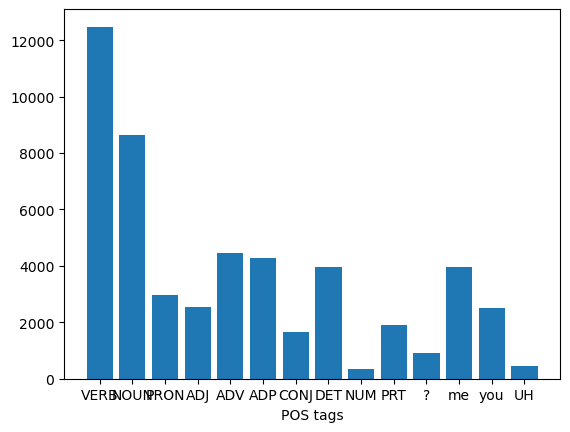

In [121]:
# plot a bar graph with the keys of the dictionary as x axis
plt.bar(np.arange(0, 14), sum_of_dict)
plt.xticks(np.arange(0, 14), ["VERB", "NOUN", "PRON", "ADJ", "ADV", "ADP", "CONJ", "DET", "NUM", "PRT", "?", "me", "you", "UH"])
plt.xlabel("POS tags")

## Generate sentence level Features

In [158]:
# generate per_time_stamp_pos
def generate_per_timestamp_pos(transcript, pos_tagging, ts):
    out_vec = np.zeros([ts.shape[0], 14])
    if len(transcript) == 0:
        return out_vec
    counter_current_word = 0
    in_word = False
    for i in range(0, ts.shape[0]):
        # if we are passed the last word then we stop, the rest of the features will be zero
        if counter_current_word >= len(pos_tagging):
            break
        # otherwise we see if we are currently in a word interval
        if ts[i] >= transcript[counter_current_word]["start"] and ts[i] <= transcript[counter_current_word]["end"]:
            # if we are we make in_word True and assign the value
            in_word = True
            out_vec[i] = pos_tagging[counter_current_word]
        else:
            while counter_current_word < len(transcript) - 2 and ts[i] > transcript[counter_current_word]["end"]:
                counter_current_word += 1
    return out_vec

# get the metadata
video_names_path = os.path.join(*[output_folder, "metadata.json"])
video_metadata = {}
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]

lengths = []
for shot_id in range(0, len(video_metadata)):
    # Get time 
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    # need gaze to figure out what the time array's shape should be 
    gaze = pkl.load(open(os.path.join(*[new_output_folder, "tgaze", file_name+".pkl"]), "rb"))
    transcript_on_screen = json.load(open(os.path.join(*[new_output_folder, "ttext", file_name+"_{}.json".format(0)]), "rb"))["text"]
    transcript_off_screen = json.load(open(os.path.join(*[new_output_folder, "ttext", file_name+"_{}.json".format(1)]), "rb"))["text"]
    pos_tagging_on_speech = pkl.load(open(os.path.join(*[new_output_folder, "tword_POS", file_name+"_{}.pkl".format(0)]), "rb"))
    pos_tagging_off_speech = pkl.load(open(os.path.join(*[new_output_folder, "tword_POS", file_name+"_{}.pkl".format(1)]), "rb"))
    # parse the transcript for sentences:
    interval_of_sentences_onscreen, ___ = parse_for_sentence_intervals(transcript_on_screen, 0.56)
    interval_of_sentences_offscreen, ___ = parse_for_sentence_intervals(transcript_off_screen, 0.56)
    # get the time array
    ts = np.arange(0, gaze.shape[0]) / fps
    off_screen_vec = generate_sentence_structure_values_real(ts, interval_of_sentences_offscreen)
    on_screen_vec = generate_sentence_structure_values_real(ts, interval_of_sentences_onscreen)
    # get the time array for pos_tagging:
    on_screen_pos_feature = generate_per_timestamp_pos(transcript_on_screen, pos_tagging_on_speech, ts)
    off_screen_pos_feature = generate_per_timestamp_pos(transcript_off_screen, pos_tagging_off_speech, ts)
    # get storage path
    sentence_location_onscreen = os.path.join(*[new_output_folder, "tsentence_timing", file_name+"_0.pkl"])
    sentence_location_offscreen = os.path.join(*[new_output_folder, "tsentence_timing", file_name+"_1.pkl"])
    pkl.dump(on_screen_vec, open(sentence_location_onscreen,  "wb"))
    pkl.dump(off_screen_vec, open(sentence_location_offscreen,  "wb"))
    on_screen_pos_feature_location = os.path.join(*[new_output_folder, "tword_POS", file_name+"_0.pkl"])
    off_screen_pos_feature_location = os.path.join(*[new_output_folder, "tword_POS", file_name+"_1.pkl"])
    pkl.dump(on_screen_pos_feature, open(on_screen_pos_feature_location, "wb"))
    pkl.dump(off_screen_pos_feature, open(off_screen_pos_feature_location, "wb"))
    


## resampling the data

In [45]:
# get the metadata
video_names_path = os.path.join(*[output_folder, "metadata.json"])
video_metadata = {}
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]
    
for shot_id in range(0, len(video_metadata)):
    # load all the data
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    gaze = pkl.load(open(os.path.join(*[new_output_folder, "tgaze", file_name+".pkl"]), "rb"))
    head = pkl.load(open(os.path.join(*[new_output_folder, "thead", file_name+".pkl"]), "rb"))
    blinks = pkl.load(open(os.path.join(*[new_output_folder, "tblinks", file_name+".pkl"]), "rb"))
    aversion = pkl.load(open(os.path.join(*[new_output_folder, "taversion_label", file_name+".pkl"]), "rb"))
    sentence_timing_on_screen = pkl.load(open(os.path.join(*[new_output_folder, "tsentence_timing", file_name+"_0.pkl"]), "rb"))
    sentence_timing_off_screen = pkl.load(open(os.path.join(*[new_output_folder, "tsentence_timing", file_name+"_1.pkl"]), "rb"))
    on_screen_pos_feature = pkl.load(open(os.path.join(*[new_output_folder, "tword_POS", file_name+"_0.pkl"]), "rb"))
    off_screen_pos_feature = pkl.load(open(os.path.join(*[new_output_folder, "tword_POS", file_name+"_1.pkl"]), "rb"))
    audio_on_screen, sr = librosa.load(os.path.join(*[new_output_folder, "taudio", file_name+"_{}.wav".format(0)]), sr=None)
    audio_off_screen, sr = librosa.load(os.path.join(*[new_output_folder, "taudio", file_name+"_{}.wav".format(1)]), sr=None)
    # resample everything to 25 fps
    # audio feature
    mfcc_a0 = psf.mfcc(audio_on_screen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, numcep=26)
    mfcc_a1 = psf.mfcc(audio_off_screen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, numcep=26)
    # resample mfcc
    ts_a = np.arange(0, mfcc_a0.shape[0]) / target_fps

    # all of the above follow the same fps
    ts_v = np.arange(0, gaze.shape[0]) / fps
    ts_target = ts_a
    # resample gaze, head, blinks, aversion and everything with 1dinterpolate
    gaze_interp = interp1d(ts_v, gaze, axis=0, bounds_error=False, fill_value="extrapolate")
    gaze_out = gaze_interp(ts_target)
    head_interp = interp1d(ts_v, head, axis=0, bounds_error=False, fill_value="extrapolate")
    head_out = head_interp(ts_target)
    blinks_interp = interp1d(ts_v, blinks, axis=0, bounds_error=False, fill_value="extrapolate")
    blinks_out = blinks_interp(ts_target)
    aversion_interp = interp1d(ts_v, aversion, axis=0, bounds_error=False, fill_value="extrapolate", kind="nearest")
    aversion_out = aversion_interp(ts_target)
    # resample sentence timing
    sentence_timing_on_screen_interp = interp1d(ts_v, sentence_timing_on_screen, axis=0, bounds_error=False, fill_value="extrapolate")
    sentence_timing_on_screen_out = sentence_timing_on_screen_interp(ts_target)
    sentence_timing_off_screen_interp = interp1d(ts_v, sentence_timing_off_screen, axis=0, bounds_error=False, fill_value="extrapolate")
    sentence_timing_off_screen_out = sentence_timing_off_screen_interp(ts_target)
    # resample pos feature
    on_screen_pos_feature_interp = interp1d(ts_v, on_screen_pos_feature, axis=0, bounds_error=False, fill_value="extrapolate")
    on_screen_pos_feature_out = on_screen_pos_feature_interp(ts_target)
    off_screen_pos_feature_interp = interp1d(ts_v, off_screen_pos_feature, axis=0, bounds_error=False, fill_value="extrapolate")
    off_screen_pos_feature_out = off_screen_pos_feature_interp(ts_target)
    
    # save features
    pkl.dump(gaze_out, open(os.path.join(*[new_output_folder, "gaze", file_name+".pkl"]), "wb"))
    pkl.dump(head_out, open(os.path.join(*[new_output_folder, "head", file_name+".pkl"]), "wb"))
    pkl.dump(blinks_out, open(os.path.join(*[new_output_folder, "blinks", file_name+".pkl"]), "wb"))
    pkl.dump(aversion_out, open(os.path.join(*[new_output_folder, "aversion_label", file_name+".pkl"]), "wb"))
    pkl.dump(sentence_timing_on_screen_out, open(os.path.join(*[new_output_folder, "sentence_timing", file_name+"_0.pkl"]), "wb"))
    pkl.dump(sentence_timing_off_screen_out, open(os.path.join(*[new_output_folder, "sentence_timing", file_name+"_1.pkl"]), "wb"))
    pkl.dump(on_screen_pos_feature_out, open(os.path.join(*[new_output_folder, "word_POS", file_name+"_0.pkl"]), "wb"))
    pkl.dump(off_screen_pos_feature_out, open(os.path.join(*[new_output_folder, "word_POS", file_name+"_1.pkl"]), "wb"))
    pkl.dump(mfcc_a0, open(os.path.join(*[new_output_folder, "audio", file_name+"_0.pkl"]), "wb"))
    pkl.dump(mfcc_a1, open(os.path.join(*[new_output_folder, "audio", file_name+"_1.pkl"]), "wb"))
    

    if mfcc_a1.shape[0] != on_screen_pos_feature_out.shape[0]:
        print("error")
    else:
        print(shot_id)        
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Filter the aversion labels to remove all aversions less than 6 frames

In [55]:
from Signal_processing_utils import get_activity_interval
# get statistics of aversion intervals
interval_length = []
modified_interval_length = []
long_interval_length = []
for shot_id in range(0, len(video_metadata)):
    # load all the data
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    aversion = pkl.load(open(os.path.join(*[new_output_folder, "aversion_label", file_name+".pkl"]), "rb"))
    ts = np.arange(0, aversion.shape[0])
    # remove all aversions less than 6 frames
    # herre 1 is direct gaze and 0 is aversion. So we flip it to get the activity interval for aversion
    aversion = 1 - aversion
    intervals = get_activity_interval(aversion, ts)
    for i in range(0, len(intervals)):
        if intervals[i][1] - intervals[i][0] < 6:
            aversion[intervals[i][0]:intervals[i][1]] = 0
        interval_length.append(intervals[i][1] - intervals[i][0]) # for visualization only
    # storing only long aversions
    aversion_long_only = aversion.copy()
    for i in range(0, len(intervals)):
        if intervals[i][1] - intervals[i][0] <= 6:
            aversion_long_only[intervals[i][0]:intervals[i][1]] = 0
        else:
            long_interval_length.append(intervals[i][1] - intervals[i][0]) # for visualization only
    intervals = get_activity_interval(aversion, ts) # for visualization only
    for i in range(0, len(intervals)): # for visualization only
        modified_interval_length.append(intervals[i][1] - intervals[i][0]) # for visualization only
    # save the files again
    pkl.dump(1 - aversion, open(os.path.join(*[new_output_folder, "aversion_label", file_name+".pkl"]), "wb"))
    pkl.dump(1 - aversion_long_only, open(os.path.join(*[new_output_folder, "long_aversion_label", file_name+".pkl"]), "wb"))
        


Text(0.5, 1.0, 'Aversion interval length distribution for aversion less than 2 seconds')

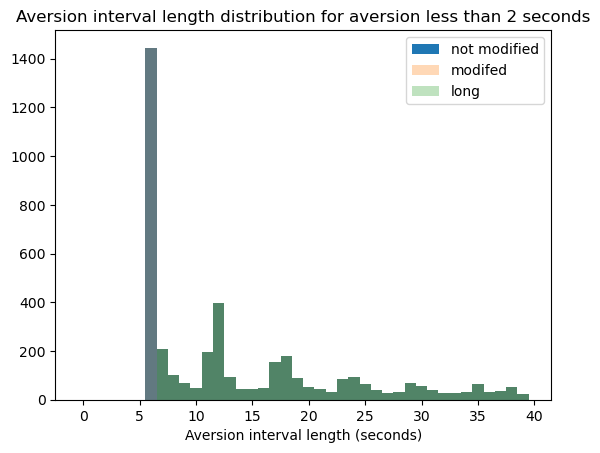

In [56]:
# filter out longer than 100 frames:
interval_length_arr = np.array(interval_length)
modified_interval_length_arr = np.array(modified_interval_length)
long_interval_length_arr = np.array(long_interval_length)
interval_length_arr = interval_length_arr[interval_length_arr<40]
modified_interval_length_arr = modified_interval_length_arr[modified_interval_length_arr<40]
long_interval_length_arr = long_interval_length_arr[long_interval_length_arr<40]
bins = np.arange(0, interval_length_arr.max() + 1.5) - 0.5
plt.hist(interval_length_arr, bins, label="not modified")
plt.hist(modified_interval_length_arr, bins, alpha= 0.3, label="modifed")
plt.hist(long_interval_length_arr, bins, alpha= 0.3, label="long")
plt.legend()
plt.xlabel("Aversion interval length (seconds)")
plt.title("Aversion interval length distribution for aversion less than 2 seconds")
# plt.xticks(bins + 0.5)
